This notebook aims to provide Recall@k and Precision@K for k =10,20,30 using images from test split of the given data

# Import Libraries

In [1]:
# Hugging Face
from transformers import AutoImageProcessor, ViTModel, DeiTModel, SwinModel,ResNetModel
from datasets import load_dataset

# torch
import torch


#others

import chromadb
from tqdm import tqdm
import collections
import random

import matplotlib.pyplot as plt
import random
import pickle
import numpy as np
import pandas as pd



2024-06-29 13:42:16.419663: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
DEVICE= torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODELS=["google/vit-base-patch16-224","microsoft/swin-tiny-patch4-window7-224","facebook/deit-base-distilled-patch16-224","microsoft/resnet-50"]

TOTAL_IMAGES=732
PR=collections.defaultdict(list)
DF=pd.DataFrame(data={"model":[],"MP@10":[],"MR@10":[],"MP@20":[],"MR@20":[],"MP@30":[],"MR@30":[]})

# Loading the Dataset and Chroma DB Client

In [3]:
ds = load_dataset("fcakyon/pokemon-classification", name="full")
d_img= ds['test'][0] # first image
d_img

{'image_file_path': '/storage/hf-datasets-cache/all/datasets/94604512981365-config-parquet-and-info-fcakyon-pokemon-classific-5a7ec0aa/downloads/extracted/0ceb06ea89e7bef2be6f73b384763d1553e8182c5b432e43e5a324d66110632a/Alakazam/1115f34ff9884a6ab3ceaafa87a0dfd4_jpg.rf.8d4fee20d6a1f27951df8c2db027356a.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'labels': 99}

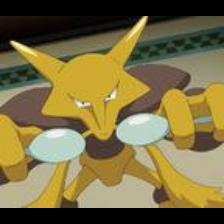

In [4]:
d_img['image']

In [5]:
len(ds["test"])

732

In [6]:
client = chromadb.PersistentClient(path="VectorDB")


In [7]:
#load the pickle file
with open('label_to_images.pkl', 'rb') as f:
    label_to_images = pickle.load(f)
len(label_to_images)

110

# Creating a Function to evaluate the similarity of images

In [8]:
def vectorize(image,processor,model,model_name):
  
  inputs = processor(image, return_tensors="pt")

  with torch.no_grad():
      outputs = model(**inputs)

  last_hidden_states = outputs.last_hidden_state
  #print(last_hidden_states.shape,model_name)
  if model_name == "microsoft/swin-tiny-patch4-window7-224":
    pooled_vector = last_hidden_states.mean(dim=1)
    #print(pooled_vector.shape,"SWIN")
    return pooled_vector
  elif model_name=="microsoft/resnet-50":
    features = outputs.pooler_output.squeeze()
    return features
  else:
    return last_hidden_states[0] # return the last hidden state without batch dimension


In [9]:
def precision(k,label_to_images,candidate_labels,query_label):
    #print(candidate_labels,query_label)
    return candidate_labels[:k].count(query_label)/k

def recall(k,label_to_images,candidate_labels,query_label):
    if query_label not in label_to_images: 
        #print("Not in label_to_images for recall")
        return 0
    return candidate_labels[:k].count(query_label)/label_to_images[query_label]


In [10]:
def getCandidates(query_id,collection,model,processor,model_name,k):
    
    if model_name=="microsoft/resnet-50":
        
        response=collection.query(
            query_embeddings=vectorize(ds["test"][query_id]["image"],processor,model,model_name).tolist(),n_results=k
        )
    else:
        response=collection.query(
            query_embeddings=vectorize(ds["test"][query_id]["image"],processor,model,model_name)[0].tolist(),n_results=k
        )
    candidate_ids=response["ids"][0]
    return candidate_ids

In [11]:
def displayImages(candidate_ids,query_id):
    print("Query Image")
    plt.imshow(ds["test"][query_id]["image"])    

    # candidate images
    print("Candidate Image")

    fig,axs = plt.subplots(2,5)
    for i, ax in enumerate(axs.flatten()):
        ax.imshow(ds["train"][int(candidate_ids[i])]["image"])
        ax.axis('off')


In [12]:
# final function to evaluate the query

def evaluate(model_name):
    
    processor = AutoImageProcessor.from_pretrained(model_name)
  
    if model_name=="microsoft/swin-tiny-patch4-window7-224":
        model = SwinModel.from_pretrained(model_name)
    elif model_name =="google/vit-base-patch16-224":
        model = ViTModel.from_pretrained(model_name)
    elif model_name == "microsoft/resnet-50":
        model = ResNetModel.from_pretrained("microsoft/resnet-50")
    else:
        model = DeiTModel.from_pretrained(model_name)
    
    index = model_name.index('/')
    name = ''.join(model_name[index+1:].split('-'))
    collection=client.get_or_create_collection(name=name,metadata={"hnsw:space": "cosine"})
    
    
    
    query_ids = [i for i in range(0,TOTAL_IMAGES)]

    for query_id in tqdm(query_ids, desc="Processing queries"):
        query_label = ds["test"][query_id]["labels"]
        for k in (10, 20, 30):
            candidate_ids = getCandidates(query_id, collection, model, processor, model_name, k)
            candidate_labels = [ds["train"][int(i)]["labels"] for i in candidate_ids]
        
            pre_k = precision(k, label_to_images, candidate_labels, query_label)
            re_k = recall(k, label_to_images, candidate_labels, query_label)
            PR[f"precision@{k}"].append(pre_k)
            PR[f"recall@{k}"].append(re_k)
            #print(PR)
        #displayImages(candidate_ids,query_id)
    
    # Calculating Means and appending to DF
    data={"model":model_name}
    for k in (10,20,30):
        data[f"MP@{k}"]=np.mean(np.array(PR[f"precision@{k}"]))
        data[f"MR@{k}"]=np.mean(np.array(PR[f"recall@{k}"]))
        #print(data[f"MP@{k}"])
        #print(data[f"MR@{k}"])
    print(data)
    DF.loc[len(DF)]=data   

In [ ]:
for model_name in MODELS:
    print(model_name)
    evaluate(model_name)

google/vit-base-patch16-224


/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing queries: 100%|██████████| 732/732 [09:10<00:00,  1.33it/s]
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not fi

{'model': 'google/vit-base-patch16-224', 'MP@10': 0.00819672131147541, 'MR@10': 0.0026032897363434913, 'MP@20': 0.006215846994535519, 'MR@20': 0.0036800661038175336, 'MP@30': 0.004872495446265938, 'MR@30': 0.00420899982947257}
microsoft/swin-tiny-patch4-window7-224


Processing queries: 100%|██████████| 732/732 [04:38<00:00,  2.63it/s]
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.

{'model': 'microsoft/swin-tiny-patch4-window7-224', 'MP@10': 0.007308743169398907, 'MR@10': 0.002423520232326942, 'MP@20': 0.005191256830601092, 'MR@20': 0.003256230186272123, 'MP@30': 0.004212204007285974, 'MR@30': 0.00383032303543169}
facebook/deit-base-distilled-patch16-224


Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Processing queries: 100%|██████████| 732/732 [09:26<00:00,  1.29it/s]
/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warn

{'model': 'facebook/deit-base-distilled-patch16-224', 'MP@10': 0.007285974499089253, 'MR@10': 0.002405536493412971, 'MP@20': 0.005418943533697631, 'MR@20': 0.003451022991307653, 'MP@30': 0.004386763812993321, 'MR@30': 0.00406449050495308}
microsoft/resnet-50


Processing queries:  95%|█████████▌| 699/732 [03:50<00:12,  2.70it/s]

In [14]:
#PR

In [ ]:
DF

In [18]:
DF.to_csv("results.csv")

In [19]:
DF

,model,MP@10,MR@10,MP@20,MR@20,MP@30,MR@30
0,google/vit-base-patch16-224,0.008197,0.002603,0.006216,0.003680,0.004872,0.004209
1,microsoft/swin-tiny-patch4-window7-224,0.007309,0.002424,0.005191,0.003256,0.004212,0.003830
2,facebook/deit-base-distilled-patch16-224,0.007286,0.002406,0.005419,0.003451,0.004387,0.004064
3,microsoft/resnet-50,0.007001,0.002270,0.005242,0.003295,0.004394,0.004004
